In [114]:
# 40,000 monthly limit requests to Directions API

In [1]:
# place = {"city": "Berkeley", "state": "California", "country": "USA"}
# G = ox.graph_from_place(place, network_type="drive")

In [2]:
# fig, ax = ox.plot_graph(G, node_size=0, dpi=600)

In [3]:
# pois = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
# X = pois.x
# Y = pois.y
#nn = ox.nearest_nodes(G, X, Y)

In [4]:
# ax = pois.to_crs(epsg=3857).plot(figsize=(20,20), alpha=1, markersize=100, edgecolor='red')
# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
# ax.set_axis_off()

In [279]:
# !conda install -c conda-forge gmaps -y
# !jupyter nbextension enable --py gmaps

# conda activate ox
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd
import contextily as cx
from shapely.prepared import prep
import shapely
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import cenpy as cp

!jupyter nbextension enable --py gmaps
with open('api_key.txt') as f:
    api_key = f.readline()
    f.close
import gmaps
gmaps.configure(api_key=api_key)
import googlemaps
from datetime import datetime
gmaps = googlemaps.Client(key=api_key)

Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK


## Pick a study location and download all the POIs in a 10-mile radius.

In [25]:
# Specify a study location (place)
place = {"city": "Berkeley", "state": "California", "country": "USA"}
# Get its centroid
place_centroid = ox.geocode_to_gdf(place).to_crs('+proj=cea').centroid.to_crs('EPSG:4326')
# Specify POI type(s)
tags = {"shop": ["supermarket", "grocery"]} # {"amenity": "fast_food", "shop": "convenience"}
# Download POIs
pois = ox.geometries.geometries_from_point((place_centroid[0].y, place_centroid[0].x), tags, dist=10*1609).reset_index()
# fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))
pois['geometry'] = pois['geometry'].to_crs('+proj=cea').centroid.to_crs('EPSG:4326')
pois.head()

element_type      osmid         brand brand:wikidata  brand:wikipedia  \
0         node  212435197  Trader Joe's        Q688825  en:Trader Joe's   
1         node  286081303           NaN            NaN              NaN   
2         node  293632937       Safeway       Q1508234  en:Safeway Inc.   
3         node  310973114           NaN            NaN              NaN   
4         node  332787306           NaN            NaN              NaN   

                      name         shop  \
0             Trader Joe's  supermarket   
1          Shattuck Market  supermarket   
2                  Safeway  supermarket   
3  Alameda Natural Grocery  supermarket   
4                  Calmart  supermarket   

                                             website  \
0   https://locations.traderjoes.com/ca/oakland/231/   
1              https://shattuck-market.business.site   
2  https://local.safeway.com/ca/san-francisco-260...   
3              http://www.alamedanaturalgrocery.com/   
4                                                NaN   

                      geometry      addr:city  ... toilets:disposal  \
0  POINT (-122.25261 37.84554)            NaN  ...              NaN   
1  POINT (-122.26711 37.86503)       Berkeley  ...              NaN   
2  POINT (-122.39423 37.77674)  San Francisco  ...              NaN   
3  POINT (-122.23969 37.76769)        Alameda  ...              NaN   
4  POINT (-122.45280 37.78626)            NaN  ...              NaN   

  toilets:wheelchair comments building_1 building_2 historic  \
0                NaN      NaN        NaN        NaN      NaN   
1                NaN      NaN        NaN        NaN      NaN   
2                NaN      NaN        NaN        NaN      NaN   
3                NaN      NaN        NaN        NaN      NaN   
4                NaN      NaN        NaN        NaN      NaN   

  historic:alt_name historic:name ways type  
0               NaN           NaN  NaN  NaN  
1               NaN           NaN  NaN  NaN  
2               NaN           NaN  NaN  NaN  
3               NaN           NaN  NaN  NaN  
4               NaN           NaN  NaN  NaN  

[5 rows x 92 columns]

## Create a grid of points/locations for mapping analysis.

262 neighborhoods


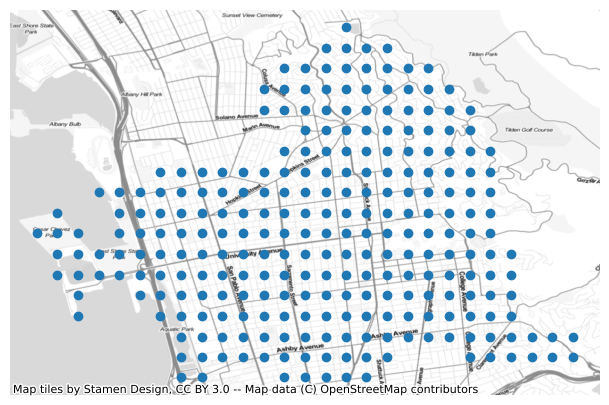

In [261]:
gdf_place = ox.geocode_to_gdf(place)

# determine maximum edges
polygon = gdf_place['geometry'][0]
latmin, lonmin, latmax, lonmax = polygon.bounds
resolution = 1/300

# create prepared polygon
prep_polygon = prep(polygon)

# construct a rectangular mesh
points = []
for lat in np.arange(latmin, latmax, resolution):
    for lon in np.arange(lonmin, lonmax, resolution):
        points.append(shapely.geometry.Point((round(lat,4), round(lon,4))))
valid_points = []
valid_points.extend(filter(prep_polygon.contains, points))
        
# Create list of points that lie within specified city.
neighborhoods = [(p.y, p.x) for p in valid_points]

nbhd_points = gpd.GeoDataFrame(geometry=[shapely.geometry.Point(n) for n in 
                  [(x, y) for x,y in zip([n[1] for n in neighborhoods], 
                                         [n[0] for n in neighborhoods])
                  ]
                 ],
                crs='EPSG:4326')
# Remove points in the water.
water_polygons = ox.geometries.geometries_from_place(place, tags={"natural": "bay"})
nbhd_points = nbhd_points[gpd.tools.sjoin(nbhd_points, water_polygons, predicate="within", how='left')['index_right0'].isna()].reset_index(drop=True)
neighborhoods = nbhd_points['geometry'].tolist()
print(len(neighborhoods), 'neighborhoods')

ax = nbhd_points.plot(figsize=(10, 5));
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs='EPSG:4326');
ax.set_axis_off();

In [265]:
buffered_nbhd_points = nbhd_points.buffer(0.7*resolution)

/var/folders/fb/qs7d795s4mz5dfcd2xc5h8n80000gn/T/ipykernel_10324/3655775827.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_nbhd_points = nbhd_points.buffer(0.7*resolution)


In [266]:
neighborhoods_contain_pois = pd.DataFrame([[buffered_nbhd_points[i].contains(pois.geometry[j]) for j in range(len(pois.geometry)) ] for i in range(len(buffered_nbhd_points))])

In [267]:
neighborhoods_contain_pois.sum(axis=1)

0      0
1      0
2      0
3      0
4      0
      ..
257    0
258    0
259    0
260    0
261    0
Length: 262, dtype: int64

In [268]:
nbhd_points

geometry
0    POINT (-122.32200 37.87240)
1    POINT (-122.31870 37.86570)
2    POINT (-122.31870 37.86910)
3    POINT (-122.31870 37.87240)
4    POINT (-122.31870 37.87570)
..                           ...
257  POINT (-122.24200 37.85570)
258  POINT (-122.23870 37.85240)
259  POINT (-122.23870 37.85570)
260  POINT (-122.23530 37.85240)
261  POINT (-122.23530 37.85570)

[262 rows x 1 columns]

In [269]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

nbhd_points_nn = ckdnearest(nbhd_points, pois)[['geometry','osmid']]
nbhd_points_nn = pd.merge(nbhd_points_nn, pois, how='left', on='osmid')
nbhd_points_nn.sample(5)

geometry_x       osmid element_type         brand  \
38   POINT (-122.29870 37.86910)  2475998084         node           NaN   
137  POINT (-122.27200 37.85910)    23226440          way           NaN   
107  POINT (-122.27870 37.86910)   775881481         node  Trader Joe's   
174  POINT (-122.26530 37.86910)   286081303         node           NaN   
171  POINT (-122.26530 37.85910)    23226440          way           NaN   

    brand:wikidata  brand:wikipedia               name         shop  \
38             NaN              NaN  Market Hall Foods  supermarket   
137            NaN              NaN      Berkeley Bowl  supermarket   
107        Q688825  en:Trader Joe's       Trader Joe's  supermarket   
174            NaN              NaN    Shattuck Market  supermarket   
171            NaN              NaN      Berkeley Bowl  supermarket   

                                               website  \
38               https://www.markethallfoodson4th.com/   
137                      https://www.berkeleybowl.com/   
107  https://locations.traderjoes.com/ca/berkeley/186/   
174              https://shattuck-market.business.site   
171                      https://www.berkeleybowl.com/   

                      geometry_y  ... toilets:disposal toilets:wheelchair  \
38   POINT (-122.30136 37.87013)  ...              NaN                NaN   
137  POINT (-122.26725 37.85701)  ...              NaN                NaN   
107  POINT (-122.27322 37.87170)  ...              NaN                NaN   
174  POINT (-122.26711 37.86503)  ...              NaN                NaN   
171  POINT (-122.26725 37.85701)  ...              NaN                NaN   

    comments building_1 building_2 historic historic:alt_name historic:name  \
38       NaN        NaN        NaN      NaN               NaN           NaN   
137      NaN        NaN        NaN      NaN               NaN           NaN   
107      NaN        NaN        NaN      NaN               NaN           NaN   
174      NaN        NaN        NaN      NaN               NaN           NaN   
171      NaN        NaN        NaN      NaN               NaN           NaN   

    ways type  
38   NaN  NaN  
137  NaN  NaN  
107  NaN  NaN  
174  NaN  NaN  
171  NaN  NaN  

[5 rows x 93 columns]

## Travel Time

In [270]:
def get_directions(origin_geom, destination_geom, mode='transit', departure_time=datetime.now()):
    directions_results = gmaps.directions(origin=(origin_geom.y, origin_geom.x), 
                                          destination=(destination_geom.y, destination_geom.x),
                                          mode=mode,
                                          departure_time=departure_time
                                         )
    distance = directions_results[0]['legs'][0]['distance']['value']
    duration = directions_results[0]['legs'][0]['duration']['value']
    return distance, duration

In [271]:
routing_results = [get_directions(nbhd_points_nn.geometry_x[i], nbhd_points_nn.geometry_y[i]) for i in range(len(nbhd_points_nn))]

In [272]:
routing_results_df = pd.DataFrame(columns=['distance', 'duration'], data=np.array(routing_results))

In [273]:
dist_dur_df = nbhd_points_nn.join(routing_results_df)

In [274]:
dist_dur_df.sample(5)

geometry_x      osmid element_type               brand  \
145  POINT (-122.27200 37.88570)   24221445          way             Safeway   
17   POINT (-122.30870 37.87910)  294213897          way  Whole Foods Market   
173  POINT (-122.26530 37.86570)  286081303         node                 NaN   
93   POINT (-122.28200 37.87240)   32456726          way                 NaN   
189  POINT (-122.26200 37.86910)  286081303         node                 NaN   

    brand:wikidata        brand:wikipedia                name         shop  \
145       Q1508234        en:Safeway Inc.             Safeway  supermarket   
17        Q1809448  en:Whole Foods Market  Whole Foods Market  supermarket   
173            NaN                    NaN     Shattuck Market  supermarket   
93             NaN                    NaN     Monterey Market  supermarket   
189            NaN                    NaN     Shattuck Market  supermarket   

                                               website  \
145  https://local.safeway.com/safeway/ca/berkeley/...   
17      https://www.wholefoodsmarket.com/stores/gilman   
173              https://shattuck-market.business.site   
93     https://en.m.wikipedia.org/wiki/Monterey_Market   
189              https://shattuck-market.business.site   

                      geometry_y  ... comments building_1 building_2 historic  \
145  POINT (-122.27002 37.88076)  ...      NaN        NaN        NaN      NaN   
17   POINT (-122.29771 37.88082)  ...      NaN        NaN        NaN      NaN   
173  POINT (-122.26711 37.86503)  ...      NaN        NaN        NaN      NaN   
93   POINT (-122.28226 37.88119)  ...      NaN        NaN        NaN      NaN   
189  POINT (-122.26711 37.86503)  ...      NaN        NaN        NaN      NaN   

    historic:alt_name historic:name ways type distance duration  
145               NaN           NaN  NaN  NaN      706      239  
17                NaN           NaN  NaN  NaN     1138      895  
173               NaN           NaN  NaN  NaN      203      139  
93                NaN           NaN  NaN  NaN     1104      820  
189               NaN           NaN  NaN  NaN     2088      672  

[5 rows x 95 columns]

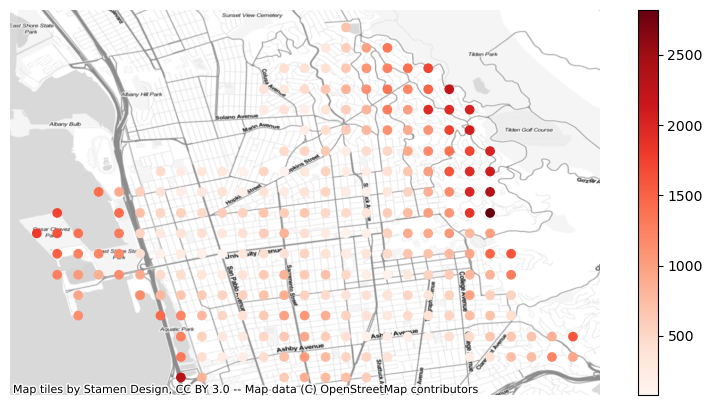

In [275]:
import matplotlib.pyplot as plt
plot_df = dist_dur_df[['geometry_x', 'duration']].set_geometry('geometry_x')
ax = plot_df.plot(figsize=(10, 5), column='duration', cmap = 'Reds', legend=True);
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=plot_df.crs);
ax.set_axis_off();

In [300]:
acs = cenpy.products.ACS()
berkeley_acs = acs.from_place('Berkeley, CA', level='tract', variables=['B25077_001E'])

Matched: Berkeley, CA to Berkeley city within layer Incorporated Places


/Users/sgangrade/opt/anaconda3/envs/ox/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/var/folders/fb/qs7d795s4mz5dfcd2xc5h8n80000gn/T/ipykernel_10324/3438277280.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  berkeley_acs = acs.from_place('Berkeley, CA', level='tract', variables=['B25077_001E'])


In [302]:
berkeley_acs

GEOID                                           geometry  \
0   06001422900  POLYGON ((-13611375.560 4561290.630, -13611365...   
1   06001423100  POLYGON ((-13613508.330 4560942.320, -13613500...   
2   06001422100  POLYGON ((-13614468.680 4562145.110, -13614458...   
3   06001423500  POLYGON ((-13611274.700 4560139.980, -13611265...   
4   06001422200  POLYGON ((-13613730.630 4561806.220, -13613714...   
5   06001422800  POLYGON ((-13610587.750 4560771.980, -13610574...   
6   06001421400  POLYGON ((-13611767.290 4563731.830, -13611760...   
7   06001421700  POLYGON ((-13611539.860 4563178.070, -13611531...   
8   06001423601  POLYGON ((-13610424.000 4559763.500, -13610374...   
9   06001421800  POLYGON ((-13612511.680 4562618.280, -13612503...   
10  06001422400  POLYGON ((-13611451.140 4562175.710, -13611444...   
11  06001423602  POLYGON ((-13610508.380 4560268.720, -13610457...   
12  06001423200  POLYGON ((-13614123.370 4560786.500, -13614113...   
13  06001422300  POLYGON ((-13612458.250 4562016.630, -13612437...   
14  06001423000  POLYGON ((-13612374.430 4561127.190, -13612359...   
15  06001423400  POLYGON ((-13612283.810 4559978.250, -13612264...   
16  06001422500  POLYGON ((-13610561.250 4562319.280, -13610534...   
17  06001423300  POLYGON ((-13613221.680 4559823.010, -13613213...   

    B25077_001E state county   tract  
0      973200.0    06    001  422900  
1      870900.0    06    001  423100  
2      845100.0    06    001  422100  
3      903600.0    06    001  423500  
4      822400.0    06    001  422200  
5           NaN    06    001  422800  
6     1329800.0    06    001  421400  
7     1025700.0    06    001  421700  
8     1046600.0    06    001  423601  
9      983800.0    06    001  421800  
10     806500.0    06    001  422400  
11     592000.0    06    001  423602  
12     892300.0    06    001  423200  
13     948200.0    06    001  422300  
14     839400.0    06    001  423000  
15     925100.0    06    001  423400  
16     923600.0    06    001  422500  
17     889600.0    06    001  423300

## Archive

In [ ]:
def dirs_from_nbhd_to_poi(nbhd, pois, mode="transit", departure_time=datetime.now()):
    """
    Returns the distances and durations FROM the provided point location TO all the POIs in pois.
    """
    directions_results = [0]*len(pois)
    distances = [0]*len(pois)
    durations = [0]*len(pois)
    for i in range(len(pois)):
            directions_results[i] = gmaps.directions(origin=nbhd,
                                                     destination=(pois.iloc[i]['geometry'].y, pois.iloc[i]['geometry'].x), # lat, lon
                                                     mode=mode, # "driving", "walking", "bicycling" or "transit"
                                                     departure_time=departure_time
                                                       )
            distances[i] = directions_results[i][0]['legs'][0]['distance']['value']
            durations[i] = directions_results[i][0]['legs'][0]['duration']['value']
    return distances, durations

In [8]:
pois_per_neighborhood = [0]*len(neighborhoods)
tick = 0
for n in range(len(neighborhoods)):
    pois_per_neighborhood[n] = ox.geometries.geometries_from_point(neighborhoods[n], tags, dist=1*1609) # 1 miles
    pois_per_neighborhood[n].reset_index(inplace=True)
    clear_output(wait=True)
    tick += 1
    print(round(100 * tick / len(neighborhoods)), "%")

100 %


In [9]:
def only_keep_points(gdf):
    if pois_per_neighborhood[0].empty:
        return gdf
    return gdf[gdf['element_type']=='node']

def dirs_from_nbhd_to_poi(nbhd, pois, mode="transit", departure_time=datetime.now()):
    """
    Returns the distances and durations FROM the provided point location TO all the POIs in pois.
    """
    directions_results = [0]*len(pois)
    distances = [0]*len(pois)
    durations = [0]*len(pois)
    for i in range(len(pois)):
            directions_results[i] = gmaps.directions(origin=nbhd,
                                                     destination=(pois.iloc[i]['geometry'].y, pois.iloc[i]['geometry'].x), # lat, lon
                                                     mode="transit", # "driving", "walking", "bicycling" or "transit"
                                                     departure_time=departure_time
                                                       )
            distances[i] = directions_results[i][0]['legs'][0]['distance']['value']
            durations[i] = directions_results[i][0]['legs'][0]['duration']['value']
    return distances, durations

In [10]:
tick = 0
distances = [0]*len(neighborhoods)
durations = [0]*len(neighborhoods)
for n in range(len(neighborhoods)):
    pois_per_neighborhood[n] = only_keep_points(pois_per_neighborhood[n])
    distances[n], durations[n] = dirs_from_nbhd_to_poi(neighborhoods[n], 
                                             pois_per_neighborhood[n], 
                                             "transit", 
                                             datetime.now())
    clear_output(wait=True)
    tick += 1
    print(round(100 * tick / len(neighborhoods)), "%")

100 %


In [11]:
dist_dur = [0] * len(neighborhoods)
for n in range(len(neighborhoods)):
    dist_dur[n] = gpd.GeoDataFrame(data={"element_type": pois_per_neighborhood[n]['element_type'], 
                                         "osmid": pois_per_neighborhood[n]['osmid'], 
                                         "distance (m)": distances[n], 
                                         "duration (s)": durations[n]
                                        }, 
                                   geometry=pois_per_neighborhood[n].geometry
                                  )

In [17]:
dist_dur[0]

element_type        osmid  distance (m)  duration (s)  \
0          node    212435197         11289          4198   
1          node    286081303          7841          3353   
2          node    343317788          8406          3420   
3          node    363915431         16209          5718   
4          node    410243509         15722          4936   
5          node    477131697          8934          3708   
6          node    612767884         29312          6330   
7          node    732040844         30194          6654   
8          node    775881481          6588          2876   
9          node    910883477          4678          2298   
10         node    910883497          5001          2487   
11         node    992416904         11005          5287   
12         node   1305397495          8370          3612   
13         node   1378041461         16274          5740   
14         node   1421106376         15345          4664   
15         node   1669811032          4960          2419   
16         node   2130264969         30183          6637   
17         node   2412716300         13653          4895   
18         node   2416941915         13528          4809   
19         node   2416945139         13311          4649   
20         node   2475998084          3637          2681   
21         node   2487652502         10749          4073   
22         node   2838479530         13579          4895   
23         node   3148123214         29403          6398   
24         node   3148123215         29346          6358   
25         node   3520676346          9295          4163   
26         node   3992953178         13286          4619   
27         node   3992986699         13984          4936   
28         node   4017211397         29138          6474   
29         node   4017220288         29156          6490   
30         node   4422423946         16824          4995   
31         node   4611235501         12817          4937   
32         node   4983814523         15786          4814   
33         node   5153772161         11184          4001   
34         node   5616585421          6803          2885   
35         node   8118795249          9495          3778   
36         node   8758993181          9957          3696   
37         node   8759011945         10178          3954   
38         node   9023293126         31955          7307   
39         node   9344941253         11344          4389   
40         node  10057579916         34561          6581   

                       geometry  
0   POINT (-122.25261 37.84554)  
1   POINT (-122.26711 37.86503)  
2   POINT (-122.29957 37.89885)  
3   POINT (-122.24438 37.80991)  
4   POINT (-122.26500 37.80272)  
5   POINT (-122.30714 37.89865)  
6   POINT (-122.40900 37.79867)  
7   POINT (-122.41289 37.80644)  
8   POINT (-122.27322 37.87170)  
9   POINT (-122.29451 37.86834)  
10  POINT (-122.29199 37.86791)  
11  POINT (-122.28668 37.89927)  
12  POINT (-122.28325 37.84233)  
13  POINT (-122.24391 37.81099)  
14  POINT (-122.26833 37.80305)  
15  POINT (-122.29220 37.86994)  
16  POINT (-122.41379 37.80548)  
17  POINT (-122.26641 37.79916)  
18  POINT (-122.26785 37.79943)  
19  POINT (-122.27002 37.80029)  
20  POINT (-122.30136 37.87013)  
21  POINT (-122.25203 37.85061)  
22  POINT (-122.25349 37.82544)  
23  POINT (-122.40854 37.79791)  
24  POINT (-122.40864 37.79841)  
25  POINT (-122.27596 37.83684)  
26  POINT (-122.27159 37.80005)  
27  POINT (-122.26851 37.79777)  
28  POINT (-122.40835 37.79697)  
29  POINT (-122.40867 37.79709)  
30  POINT (-122.35697 37.93458)  
31  POINT (-122.24878 37.83473)  
32  POINT (-122.34787 37.93757)  
33  POINT (-122.31546 37.92222)  
34  POINT (-122.29788 37.88521)  
35  POINT (-122.28024 37.82949)  
36  POINT (-122.30536 37.90582)  
37  POINT (-122.30773 37.91099)  
38  POINT (-122.41878 37.80913)  
39  POINT (-122.26163 37.83744)  
40  POINT (-122.37045 37.82639)

In [21]:
mean_distance_per_neighborhood = [df['distance (m)'].mean() for df in dist_dur]
mean_duration_per_neighborhood = [df['duration (s)'].mean() for df in dist_dur]
print(mean_distance_per_neighborhood)
print(mean_duration_per_neighborhood)

[15201.951219512195, 7588.941176470588, 6961.5, 9594.142857142857]
[4661.317073170731, 2223.235294117647, 1389.0882352941176, 2784.9523809523807]


In [107]:
lon = [n[1] for n in neighborhoods]
lat = [n[0] for n in neighborhoods]
nbhd_lon_lat = [(x, y) for x,y in zip(lon, lat)]
summary_gdf = gpd.GeoDataFrame(data = {'mean distance (m)': mean_distance_per_neighborhood,
                                       'mean duration (s)': mean_duration_per_neighborhood},
                               geometry = [shapely.geometry.Point(n) for n in nbhd_lon_lat],
                               crs = 'epsg:4326'
                              ).to_crs('epsg:3857')
del lon, lat, nbhd_lon_lat

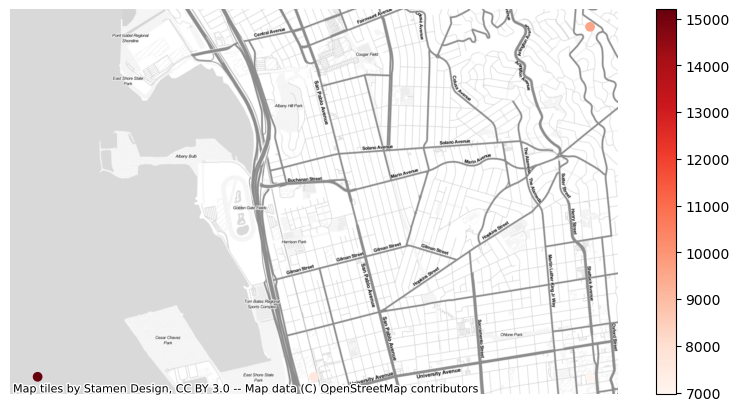

In [113]:
import matplotlib.pyplot as plt

# ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# ax.set_axis_off()
ax = summary_gdf.plot(figsize=(10, 5), column='mean distance (m)', cmap = 'Reds', legend=True);
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=summary_gdf.crs);
ax.set_axis_off();